In [167]:
import json
import os
import numpy as np
import pandas as pd
import emoji
from enchant.checker import SpellChecker

dirs = ["sejal", "camille", "erika"]

# function to count the number of emojis in a given caption
def text_has_emoji(text):
    num_emojis = 0
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            num_emojis += 1
    return num_emojis

# function to verify if a given caption is predominantly English
max_error_count = 3
min_text_length = 3
def is_in_english(quote):
    quote = quote.lower()
    quote = ' '.join([word for word in quote.split() if word[0] != "#" and word[0] != "@"])
    if len(quote.split()) <= 1:
        return True
    d = SpellChecker("en_US")
    d.set_text(quote)
    errors = [err.word for err in d]
    if len(quote.split()) <= 5 and len(errors) > max_error_count:
        return False
    elif len(quote.split()) > 5 and len(errors) >= 0.8*len(quote.split()):
        return False
    else:
        return True

identifier, photos, captions = [], [], []
collections, no_image, no_caption, too_few, non_english = 0, 0, 0, 0, 0
scraper_failed, running_total = 0, 0
posts_per_user = []
mentions, hashtags, emojis, has_quotes, vanilla = 0, 0, 0, 0, 0
finsta, finsta_users = 0, 0
root_count, root_user_count, valid_post_count = [0, 0, 0], [0, 0, 0], [0, 0, 0]
non_english_captions = []
total_h, total_m, total_e = 0, 0, 0
for i, root in enumerate(dirs):
    for fn in os.listdir("profiles/profiles_" + root + "/"):
        if fn.endswith(".json"):
            f = open("profiles/profiles_" + root + "/" + fn)
            root_user_count[i] += 1
            num_valid_entries = 0
            num_invalid_entries = 0
            user_identifiers, user_photos, user_captions = [], [], []
            h, m, q, e, v = 0, 0, 0, 0, 0
            data = json.load(f)
            posts = data["posts"]
            root_count[i] += len(posts)
            if data["followers"]["count"] >= 200:
                for p in posts:
                    if len(p["imgs"]) > 1:
                        collections += 1
                        num_invalid_entries += 1
                    elif len(p["imgs"]) == 0:
                        no_image += 1
                        num_invalid_entries += 1
                    elif p["caption"] == "":
                        no_caption += 1
                        num_invalid_entries += 1
                    elif is_in_english(p["caption"]) == False:
                        non_english_captions.append(p["caption"])
                        non_english += 1
                        num_invalid_entries += 1
                    else:
                        num_valid_entries += 1
                        vanilla_flag = True
                        user_identifiers.append(data["username"])
                        user_photos.append(p["imgs"][0])
                        if '"' in p["caption"]:
                            q += 1
                            vanilla_flag = False
                        if '@' in p["caption"]:
                            m += 1
                            vanilla_flag = False
                        if '#' in p["caption"]:
                            h += 1
                            vanilla_flag = False
                        for char in p["caption"]:
                            if char == "@":
                                total_m += 1
                            if char == "#":
                                total_h += 1
                        emojis_in_caption = text_has_emoji(p["caption"])
                        if emojis_in_caption != 0:
                            e += 1
                            total_e += emojis_in_caption
                            vanilla_flag = False
                        if vanilla_flag:
                            v += 1
                        user_captions.append(p["caption"].replace('"', '\''))
                if num_valid_entries >= 10:
                    running_total += num_valid_entries
                    valid_post_count[i] += num_valid_entries
                    hashtags += h
                    has_quotes += q
                    mentions += m
                    emojis += e
                    vanilla += v
                    identifier.append(user_identifiers)
                    photos.append(user_photos)
                    captions.append(user_captions)
                else:
                    too_few += num_valid_entries
                posts_per_user.append(num_valid_entries)
                if data["num_of_posts"] < 100:
                    scraper_failed += data["num_of_posts"] - num_valid_entries - num_invalid_entries
                else:
                    scraper_failed += 100 - num_valid_entries - num_invalid_entries
            else:
                finsta += len(data["posts"])
                finsta_users += 1
                posts_per_user.append(len(data["posts"]))
            f.close()
        
print("total hashtags:", total_h)
print("total mentions:", total_m)
print("total emojis:", total_e)

# PRINT SUMMARY REPORT
left_space = 20
num_space = 8
throwing_out = collections + no_image + no_caption + too_few + finsta + non_english
total = running_total + throwing_out
total_users = len(posts_per_user)
print("classification".ljust(left_space), "# posts".rjust(num_space), "pct %".rjust(num_space), "# users".rjust(num_space), "pct %".rjust(num_space))
print("––––––––––––––––––".ljust(left_space), "––––––".rjust(num_space), "––––––".rjust(num_space), "––––––".rjust(num_space), "––––––".rjust(num_space))
print("scraper failed".ljust(left_space), str(scraper_failed).rjust(num_space), str(round(scraper_failed * 100/ (total + scraper_failed), 2)).rjust(num_space))
print("TOTAL SCRAPED".ljust(left_space), ("("+str(total)+")").rjust(num_space), str(round(100, 2)).rjust(num_space), ("("+str(total_users)+")").rjust(num_space), str(round(100, 2)).rjust(num_space))
posts_per_user2 = [p for p in posts_per_user if p >= 10]
for i in range(len(root_count)):
    print(dirs[i].ljust(left_space), str(root_count[i]).rjust(num_space), str(round(root_count[i] * 100 / total, 2)).rjust(num_space), 
          str(root_user_count[i]).rjust(num_space), str(round(root_user_count[i] * 100 / total_users, 2)).rjust(num_space))
# print("median ppu [before]".ljust(left_space), str(np.median(posts_per_user)).rjust(num_space))
# print("median ppu [after]".ljust(left_space), str(np.median(posts_per_user2)).rjust(num_space))
print("")

print("THROWING OUT".ljust(left_space), ("(" + str(throwing_out) + ")").rjust(num_space), ("("+str(round(throwing_out * 100 / total, 2))+")").rjust(num_space), 
      str(total_users - len(posts_per_user2)).rjust(num_space), str(round((total_users - len(posts_per_user2)) * 100 / total_users, 2)).rjust(num_space))
print("no caption".ljust(left_space), str(no_caption).rjust(num_space), str(round((no_caption / total) * 100, 2)).rjust(num_space))
print("no image".ljust(left_space), str(no_image).rjust(num_space), str(round((no_image / total) * 100, 2)).rjust(num_space))
print("collection".ljust(left_space), str(collections).rjust(num_space), str(round((collections / total) * 100, 2)).rjust(num_space))
print("too few posts".ljust(left_space), str(too_few).rjust(num_space), str(round((too_few / total) * 100, 2)).rjust(num_space))
print("low num followers".ljust(left_space), str(finsta).rjust(num_space), str(round((finsta / total) * 100, 2)).rjust(num_space))
print("non-english".ljust(left_space), str(non_english).rjust(num_space), str(round((non_english / total) * 100, 2)).rjust(num_space))

print("")

print("USABLE".ljust(left_space), ("(" + str(running_total) + ")").rjust(num_space), ("("+str(round(running_total*100/total, 2))+")").rjust(num_space))
print("<< plain text >>".ljust(left_space), str(vanilla).rjust(num_space), str(round((vanilla / total) * 100, 2)).rjust(num_space))
nonvanilla = running_total - vanilla
print("<< special chars >>".ljust(left_space), str(nonvanilla).rjust(num_space), str(round((nonvanilla / total) * 100, 2)).rjust(num_space))
print("   mentions".ljust(left_space), str(mentions).rjust(num_space), str(round((mentions / total) * 100, 2)).rjust(num_space))
print("   hashtags".ljust(left_space), str(hashtags).rjust(num_space), str(round((hashtags / total) * 100, 2)).rjust(num_space))
print("   emojis".ljust(left_space), str(emojis).rjust(num_space), str(round((emojis / total) * 100, 2)).rjust(num_space))
print("   has quotes".ljust(left_space), str(has_quotes).rjust(num_space), str(round((has_quotes / total) * 100, 2)).rjust(num_space))

with open('masterdata.csv', 'w') as f:
    f.write("username,photo,caption\n")
    for i in range(len(photos)):
        for j in range(len(photos[i])):
            f.write("%s,%s,\"%s\"\n" % (identifier[i][j],photos[i][j], captions[i][j]))

with open('non-english_captions.txt', 'w') as outfile:
    for caption in non_english_captions:
        outfile.write(caption + "\n\n")

try:
    csv = pd.read_csv('masterdata.csv', header=0)
    csv.drop_duplicates(keep="last",inplace=True)
    csv.to_csv('masterdata.csv', index=False)
except:
    print('pandas stuff did not work')


52070 9783 63535
classification        # posts    pct %  # users    pct %
––––––––––––––––––     ––––––   ––––––   ––––––   ––––––
scraper failed          37563    22.33
TOTAL SCRAPED        (130632)      100   (2791)      100
sejal                   43230    33.09     1100    39.41
camille                 57154    43.75     1114    39.91
erika                   30248    23.16      577    20.67

THROWING OUT          (48885)  (37.42)      907     32.5
no caption               8277     6.34
no image                 3574     2.74
collection              28413    21.75
too few posts            2766     2.12
low num followers        5492      4.2
non-english               363     0.28

USABLE                (81747)  (62.58)
<< plain text >>        35147    26.91
<< special chars >>     46600    35.67
   mentions              6862     5.25
   hashtags             17071    13.07
   emojis               31566    24.16
   has quotes            1437      1.1


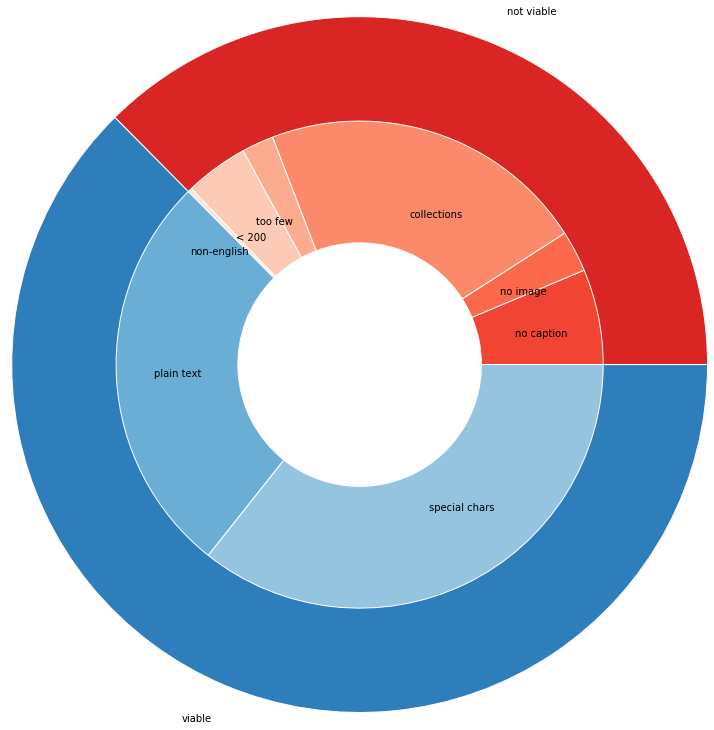

In [168]:
import matplotlib.pyplot as plt
 
# Make data: I have 2 groups and 8 subgroups
group_names=['not viable', 'viable']
group_size=[throwing_out, running_total]
subgroup_names=["no caption", "no image", "collections", "too few", "< 200", "non-english", "plain text", "special chars"]
subgroup_size = [no_caption, no_image, collections, too_few, finsta, non_english, vanilla, nonvanilla]
 
# Create colors
a, b = [plt.cm.Reds, plt.cm.Blues]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=4, labels=group_names, colors=[a(0.7), b(0.7)] )
plt.setp( mypie, width=1.4, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=4-1.2, labels=subgroup_names, labeldistance=0.65, colors=[a(0.6), a(0.5), a(0.4), a(0.3), a(0.2), a(0.1), b(0.5), b(0.4)])
plt.setp( mypie2, width=1.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.show()
fig.savefig('piechart_distribution.png', bbox_inches='tight', pad_inches=1)

In [169]:
import networkx as nx
from netwulf import visualize

# Create graph
G = nx.Graph()

# Add nodes
# valence nodes = "scrapees" or users who got their data scraped
# core nodes = "scrapers" or accounts from which we scraped data
nodes = [[], [], []]
core_nodes = ['sejaldua99', 'camillebowman', 'erikaaanakagawa']
for i, root in enumerate(dirs):
    for fn in os.listdir("profiles/profiles_" + root + "/"):
        if fn.endswith(".json"):
            nodes[i].append(fn[0:fn.find('2019')-1])

# Add edges
# edges = "scraper-scrapee" relationship
for i in range(len(nodes)):
    G.add_nodes_from(nodes[i])
    for c in nodes[i]:
        G.add_edge(c, core_nodes[i])

# indicates how many users are in the dataset
print(len(G.edges))

# will launch a local host through which to interact with the network
visualize(G)

2658


(None, None)